# MNIST using RNN

Also check https://github.com/MorvanZhou/tutorials/blob/master/tensorflowTUT/tf20_RNN2/full_code.py

And https://www.youtube.com/watch?v=SeffmcG42SY

## Getting Started

* Import the library to use.
* This example uses tensorflow.
* Datasets use the mnist dataset provided by tensorflow.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf 

import os
import time

tf.reset_default_graph()
%matplotlib inline

## Loading the dataset

* Load the dataset you want to use.
* Images: Monochrome images written in cursive from 0 to 9 (1 channel).
* Label: Set to one_hot format.

- 0 = [1 0 0 0 0 0 0 0 0 0]
- 1 = [0 1 0 0 0 0 0 0 0 0]

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
print("Number of train data is %d" % (mnist.train.num_examples))
print("Number of test data is %d" % (mnist.test.num_examples))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Number of train data is 55000
Number of test data is 10000


In [3]:
# set random seed for comparing results
tf.set_random_seed(1)

## Checking the dataset

Check the image and label of the training data.

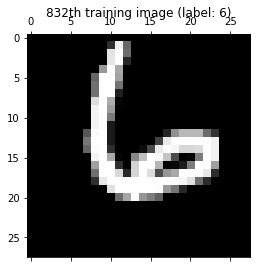

In [4]:
nsample = 1
rand_idx = np.random.randint(mnist.train.images.shape[0], size=nsample)

for i in rand_idx:
    curr_img = np.reshape(mnist.train.images[i, :], (28,28))
    curr_lbl = np.argmax(mnist.train.labels[i, :])
    plt.matshow(curr_img, cmap=plt.get_cmap('gray'))
    plt.title(""+str(i)+"th training image "
              + "(label: " + str(curr_lbl) + ")")
    plt.show()

## Configuring RNNs for Image Classification

Configure the 28x28 image as shown below for RNN input.

* Input_vec_size: Use one of the images (28x28) as an input to the RNN.
* Time_step_size: 28 lines are required to enter a single image (28x28). Therefore, time_step is 28.
* Lstm_size: number of hidden units in the rnn_cell

In [5]:
# configuration
#                        O * W + b -> 10 labels for each image, O[? 28], W[28 10], B[10]
#                       ^ (O: output 28 vec from 28 vec input)
#                       |
#      +-+  +-+       +--+
#      |1|->|2|-> ... |28| n_steps = 28
#      +-+  +-+       +--+
#       ^    ^    ...  ^
#       |    |         |
# img1:[28] [28]  ... [28]
# img2:[28] [28]  ... [28]
# img3:[28] [28]  ... [28]
# ...
# img128 or img256 (batch_size or test_size 128 or 256)

In [23]:
# hyperparameters

n_epochs_experiment1 = 40000 
n_epochs_experiment2 = 5
lr = 0.001
decay = 0.9

batch_size = 256 

n_inputs = 28   # MNIST data input or chunk_size (img shape: 28*28)
n_steps = 28    # time_step_size or n_chunks

n_hidden_units = 128 #Is the LSTM size

n_classes = 10 #MNIST classes (0-9 digits)

In [7]:
def recurrent_neural_network(x):
    layer = {'weights':tf.Variable(tf.random_normal([n_hidden_units,n_classes])),
             'biases':tf.Variable(tf.random_normal([n_classes]))}

    x = tf.transpose(x, [1,0,2])
    x = tf.reshape(x, [-1, n_inputs])
    x = tf.split(axis=0, num_or_size_splits=n_inputs, value=x)

    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden_units)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    output = tf.matmul(outputs[-1],layer['weights']) + layer['biases']

    return output, states

## Data conversion

* Reshape training and test data from 1d to 2d.
* Declare a placeholder for input and output

In [8]:
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
trX = trX.reshape(-1, n_steps, n_inputs)
teX = teX.reshape(-1, n_steps, n_inputs)

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs]) # size (128,28,28)
Y = tf.placeholder(tf.float32, [None, n_classes])         # size (128,10)

## Model

* Generate model for size of hidden unit and output unit
* Create a model

In [9]:
py_x, state_size = recurrent_neural_network(X)

## Declare and optimize the loss function

In [11]:
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=py_x, labels=Y))
#optimizer = tf.train.RMSPropOptimizer(lr, decay).minimize(cost)
optimizer = tf.train.AdamOptimizer(lr).minimize(cost)
#predict_op = tf.argmax(py_x, 1)
# Evaluate model
correct_pred = tf.equal(tf.argmax(py_x,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Execute the model

* There are two examples on how to train and test the model.

In [20]:
# Initializing the variables
init = tf.global_variables_initializer()
display_step = 10

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < n_epochs:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_inputs))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={X: batch_x, Y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={X: batch_x, Y: batch_y})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")

    # Calculate accuracy for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_inputs))
    test_label = mnist.test.labels[:test_len]
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: test_data, Y: test_label}))
    
    
    
    predict_op = tf.argmax(py_x, 1)

Iter 2560, Minibatch Loss= 1.777941, Training Accuracy= 0.39062
Iter 5120, Minibatch Loss= 1.480698, Training Accuracy= 0.49219
Iter 7680, Minibatch Loss= 1.174730, Training Accuracy= 0.57031
Iter 10240, Minibatch Loss= 1.026648, Training Accuracy= 0.65625
Iter 12800, Minibatch Loss= 0.849184, Training Accuracy= 0.71484
Iter 15360, Minibatch Loss= 0.656576, Training Accuracy= 0.80078
Iter 17920, Minibatch Loss= 0.600989, Training Accuracy= 0.76562
Iter 20480, Minibatch Loss= 0.562003, Training Accuracy= 0.82031
Iter 23040, Minibatch Loss= 0.393789, Training Accuracy= 0.89453
Iter 25600, Minibatch Loss= 0.321680, Training Accuracy= 0.89062
Iter 28160, Minibatch Loss= 0.242234, Training Accuracy= 0.92969
Iter 30720, Minibatch Loss= 0.273883, Training Accuracy= 0.91016
Iter 33280, Minibatch Loss= 0.329709, Training Accuracy= 0.91016
Iter 35840, Minibatch Loss= 0.399643, Training Accuracy= 0.87891
Iter 38400, Minibatch Loss= 0.404943, Training Accuracy= 0.88281
Optimization Finished!
Testi

In [22]:
# Launch the graph in a session
test_size = 256

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())

    for i in range(n_epochs):
        for start, end in zip(range(0, len(trX), batch_size), range(batch_size, len(trX)+1, batch_size)):
            sess.run(optimizer, feed_dict={X: trX[start:end], Y: trY[start:end]})

        test_indices = np.arange(len(teX))  # Get a Test Batch
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:test_size]

        print(i, sess.run(accuracy, feed_dict={X: teX[test_indices], Y: teY[test_indices]}))

0 0.941406
1 0.945312
2 0.980469
3 0.976562
4 0.96875
